In [12]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.io import loadmat
from scipy.fftpack import fft, ifft
from scipy import signal

import general
import eegFilter

filename = "180903-3-5.mat"
datadir = "../../Data/Chen Zhou/EEG/Compact"
resultdir = "../../Result/"
data = loadmat(os.path.join(datadir, filename))
channels = data["channels"]
markers = data["markers"][0,:]
times = data["times"][0,:]

In [51]:
chidx = 98
cue_onset = markers['grating'][0][0,:]

fs = 2000
roi = (-2,5)
ch_raw = channels[chidx,:]
ch_split = general.split_datawithmarker(ch_raw, cue_onset, roi, fs)

/usr/local/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


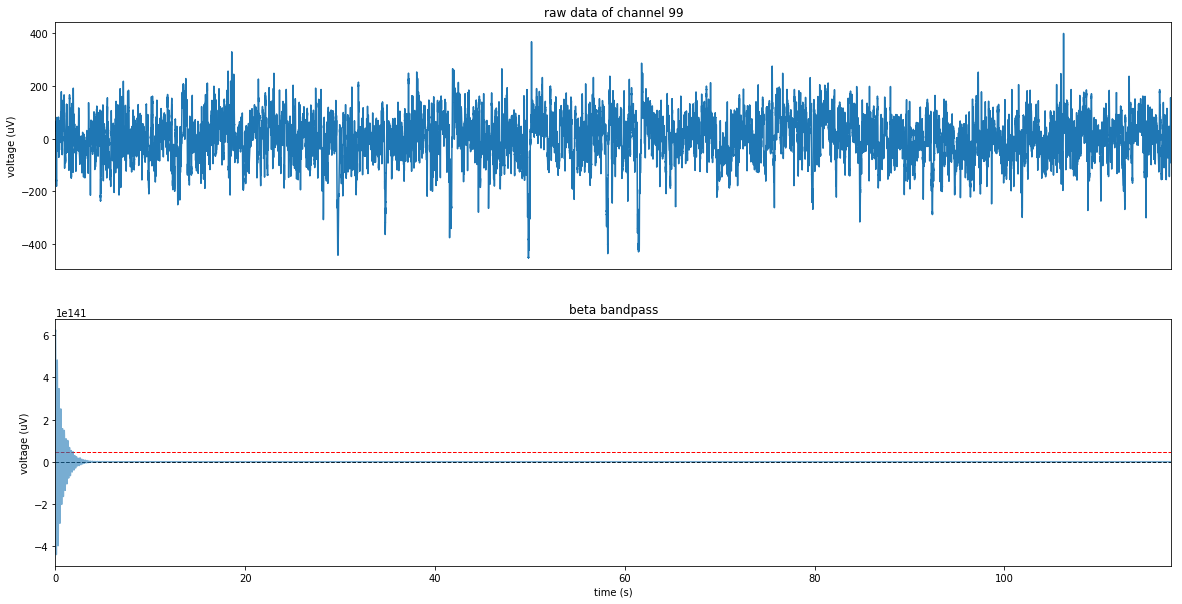

In [60]:
targetband = "beta"
lowcut, highcut = eegFilter.getbandrange(targetband)
a, b = signal.butter(4, [lowcut/fs/2, highcut/fs/2], btype="bandpass")
ch_raw_bp = signal.filtfilt(a,b,ch_raw)

ch_raw_bp_mu = np.mean(ch_raw_bp)
ch_raw_bp_sig = np.std(ch_raw_bp)

plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.plot(times, ch_raw)
plt.xlim([times[0], times[-1]])
plt.xticks([])
plt.title("raw data of channel %d"%(chidx+1))
plt.ylabel("voltage (uV)")
# plt.xlabel("time (s)")

plt.subplot(2,1,2)
plt.plot(times, ch_raw_bp, alpha=0.6)
plt.hlines(ch_raw_bp_mu, times[0], times[-1], linestyle='--', linewidth=1)
plt.hlines(ch_raw_bp_mu+ch_raw_bp_sig*2, times[0], times[-1], 'r',linestyle='--', linewidth=1)
# plt.vlines(cue_onset, np.min(ch_raw_bp), np.max(ch_raw_bp), linewidth=1)

plt.xlim([times[0], times[-1]])
# plt.xlim([1,8])
plt.title("%s bandpass"%targetband)
plt.ylabel("voltage (uV)")
plt.xlabel("time (s)")

plt.show()

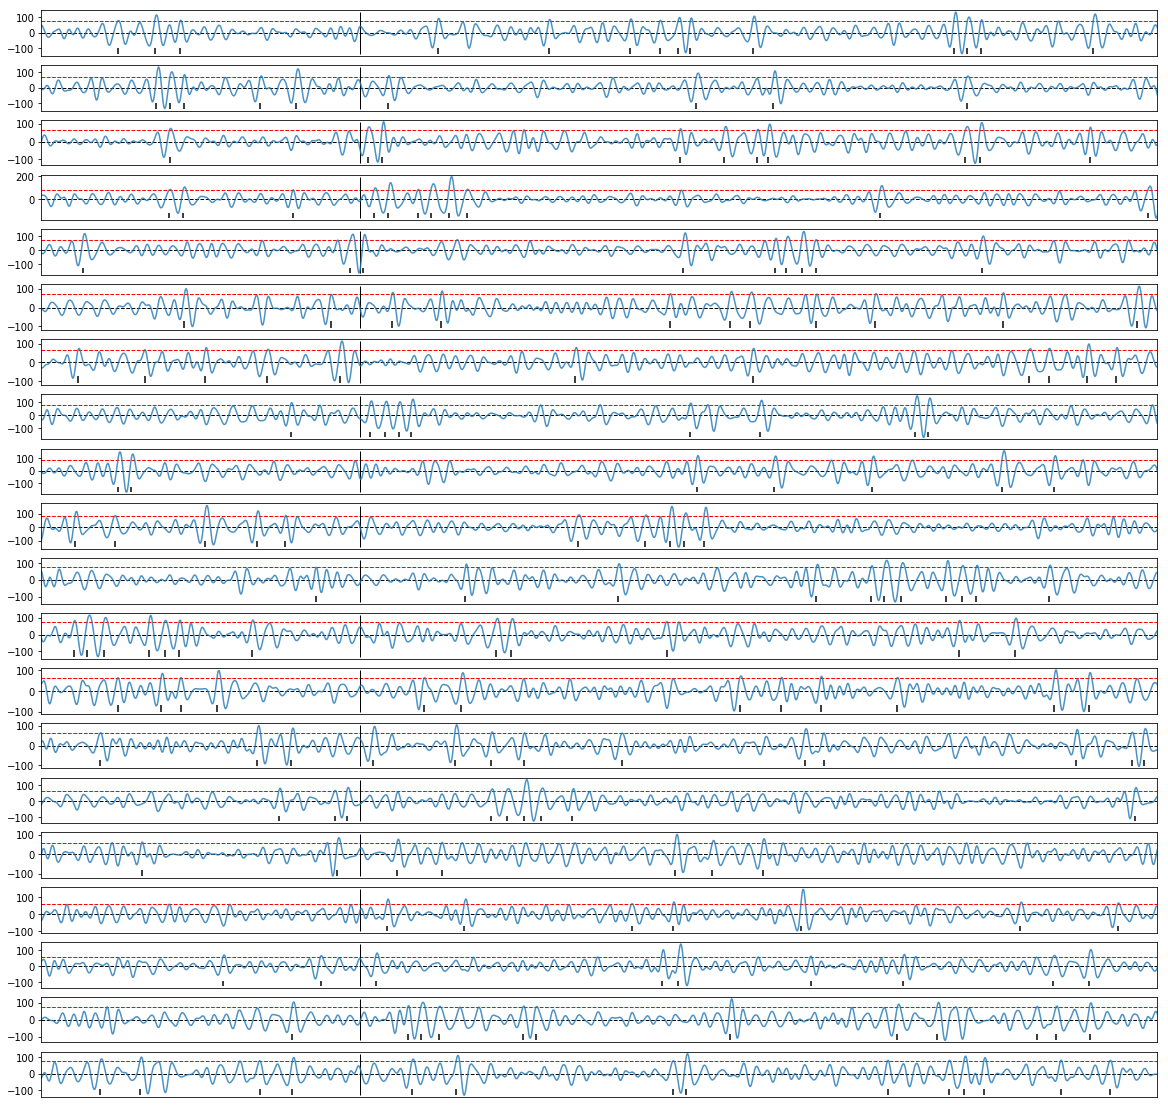

In [57]:
ch_raw_bp_split = general.split_datawithmarker(ch_raw_bp, cue_onset, roi, fs)
trialtotal = np.size(cue_onset)
tspec = np.linspace(-2,5,7*fs)
nthresh = 2

spiketrain = []

plt.figure(figsize=(20,1*trialtotal))

for trialN in range(trialtotal):
    ch_bp = ch_raw_bp_split[trialN,:]

    ch_bp_mu = np.mean(ch_bp)
    ch_bp_sig = np.std(ch_bp)

    spike = general.group_consecutive(np.where(ch_bp > ch_bp_mu+ch_bp_sig*nthresh)[0])
    spike = [item[0] for item in spike if len(item)>0]
    spiketrain.append(spike)
    
    plt.subplot(trialtotal, 1, trialN+1)

    plt.plot(tspec, ch_bp, alpha=.8)
    plt.hlines(ch_bp_mu, tspec[0], tspec[-1], linestyle='--', linewidth=1)
    plt.hlines(ch_bp_mu+ch_bp_sig*nthresh, tspec[0], tspec[-1], 'r',linestyle='--', linewidth=1)
    plt.vlines(0, np.min(ch_bp), np.max(ch_bp), linewidth=1)
    plt.vlines(tspec[spike], np.min(ch_bp), np.min(ch_bp)+ch_bp_sig)

    plt.xlim([tspec[0], tspec[-1]])
    plt.xticks([])

plt.show()

# plt.figure(figsize=(10,5))
# for trialN in range(trialtotal):
#     plt.vlines(tspec[spiketrain[trialN]], trialN+0.5, trialN+1.5)
# plt.yticks(np.linspace(1,trialtotal,trialtotal), np.linspace(1,trialtotal,trialtotal,dtype='int'))
# plt.show()

---
# Misc

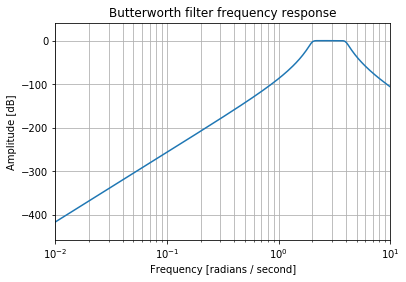

In [20]:
# Butterworth Filter
b, a = signal.butter(8, [2, 4], 'bandpass', analog=True)
w, h = signal.freqs(b, a)
plt.plot(w, 20 * np.log10(abs(h)))
plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.show()

In [11]:
# Morlet Wavelet Transform

def dwt_morlet(eeg_data, fs, frange):
    # wavelet parameters
    wtime = np.linspace(-1,1,2*fs)
    nConv = np.size(eeg_data) + 2*fs
    fft_eeg = fft(eeg_data, nConv)
    
    conv = np.zeros((np.size(frange), np.size(eeg_data)))
    for idx, F in enumerate(frange):
        s = 6 / (2 * np.pi * F)
        wavelet = np.exp(2*1j*np.pi*wtime*F) * np.exp(- wtime**2/(2*s**2))  # morlet wavelet
        fft_wavelet = fft(wavelet, nConv)
        
        conv_wave = ifft(fft_wavelet*fft_eeg, nConv)
        conv_wave = conv_wave[fs:-fs]
        
        conv[idx, :] = conv_wave

    return conv

dwtresult = dwt_morlet(ch_raw, fs, np.linspace(30, 80, 20), )

/usr/local/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


(0, 19)

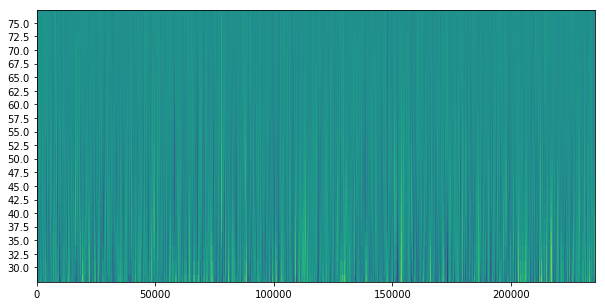

In [19]:
plt.figure(figsize=(10,5))
plt.imshow(dwtresult, aspect='auto')
plt.yticks(np.linspace(1, 20, 21), np.linspace(30, 80, 21))
plt.ylim([0,19])

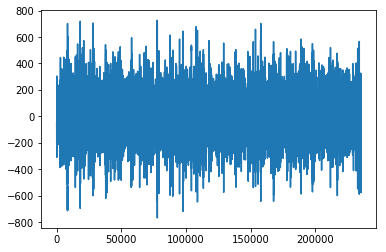

In [21]:
plt.plot(np.mean(dwtresult,0))